<a href="https://colab.research.google.com/github/deedeeharris/Mask_RCNN/blob/main/mask_rcnn_run_on_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MASK R-CNN: Run a trained model on an image

(this should work fine for tomato plant flowers)

Yedidya Harris, 28/12/2022

## 1. Setup step a

In [1]:
# !wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64/libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb
# !dpkg -i libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb
# !ls -l /usr/lib/x86_64-linux-gnu/libcudnn.so.*
#!pip install -U -qq tensorflow==2.5.0
# exit() # Runtime restart required!

In [2]:
# run terminal comomands
!pip install -U -qq tensorflow==2.5.0
exit() # Runtime restart required!

     |████████████████████████████████| 454.4 MB 45 kB/s 
     |████████████████████████████████| 132 kB 80.1 MB/s 
     |████████████████████████████████| 462 kB 76.2 MB/s 
     |████████████████████████████████| 1.2 MB 53.6 MB/s 
     |████████████████████████████████| 14.9 MB 59.3 MB/s 
     |████████████████████████████████| 4.0 MB 62.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 2022.12.0 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
xarray-einstats 0.4.0 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
pydantic 1.10.2 requires typing-extensions>=4.1.0, but you have typing-extensions 3.7.4.3 which is incompatible.
jaxlib 0.3.25+cuda11.cudnn805 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
jax 0.3.25 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.

In [3]:
#!git clone https://github.com/deedeeharris/Mask_RCNN

## 2. Setup step b

In [7]:
# import libs
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw

!git clone https://github.com/deedeeharris/Mask_RCNN

ROOT_DIR = 'Mask_RCNN'

sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


In [8]:
class TrainConfig(Config):
    # Give the configuration a recognizable name
    NAME = "custom"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 5

    LEARNING_RATE = 0.001

    # Number of classes (including background) - IMPORTANT TO CHANGE ACCORDING TO YOUR LABELS IN YOUR JSON
    NUM_CLASSES = 1 + 1  # background + 1 (flowers)

    # All of our training images are 1920x1012
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50' # resnet50

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = TrainConfig()
#config.display()

In [9]:
# download the trained model (tomato flowers)
!pip install -U --no-cache-dir gdown --pre -qq

import gdown

file_id = '1-5X-iKVw-W51DOtQ_R5wJnMhUjU_c2ux'
model_filename = 'model.h5'
gdown.download(f'https://drive.google.com/u/0/uc?id={file_id}', model_filename)

Downloading...
From: https://drive.google.com/u/0/uc?id=1-5X-iKVw-W51DOtQ_R5wJnMhUjU_c2ux
To: /content/model.h5
100%|██████████| 184M/184M [00:00<00:00, 213MB/s]


'model.h5'

In [10]:
class InferenceConfig(TrainConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.65 # CHANGE HERE IF YOU WANT

inference_config = InferenceConfig()

# Recreate the model in inference mode
test_model = modellib.MaskRCNN(
    mode="inference", 
    config=inference_config,
    model_dir='/content')

model_path = f'/content/{model_filename}'
print(model_path)

test_model.load_weights(model_path, by_name=True)

/content/model.h5


In [11]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

In [12]:
# get classnames
dataset_train = CocoLikeDataset()
dataset_train.load_data('/content/Mask_RCNN/train.json', '/content')
dataset_train.prepare()
class_names = dataset_train.class_names

In [13]:
import skimage

mask_colors = [
    (0., 0., 0.), # Background (class 0)
    (1., 0., 0.)#, # Flower (class 1)
    #(0., 1., 0.)  # Add here, for other classes
]


def mask_image(img):
  img_arr = np.array(img)

  results = test_model.detect([img_arr], verbose=1)
  r = results[0]

  colors = tuple(np.take(mask_colors, r['class_ids'], axis=0))

  visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                              class_names, r['scores'], figsize=(16, 8), 
                              colors=colors)
  return r

## 3. Load image and Run

Saving image24.jpg to image24.jpg
Processing 1 images
image                    shape: (159, 318, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


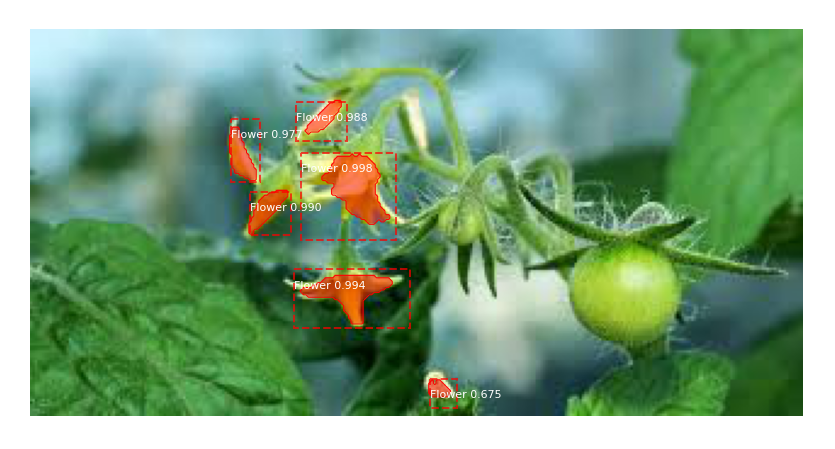

In [16]:
#@title  Run me

# libs
from google.colab import files
from matplotlib import pyplot as plt
from skimage import io

# upload an image 
uploaded = files.upload()
img_path = list(uploaded.keys())[0]
img = io.imread(img_path)

# call our function
result = mask_image(img) 